In [1]:
import sys
sys.path.append('../')
import train
from model import *
from lib.training import *
from lib.preprocessing import single_transforms 
from lib.dataloading import *
from lib.loss_functions import *
from lib.evaluation import *
from torchvision import transforms
from torch import optim, nn
import random

In [2]:
%matplotlib inline

In [3]:
transform = single_transforms.get_transformer_norm()
dataset = SSIDataset(img_file = '/media/jimmy/224CCF8B4CCF57E5/Data/SSI/ssi.csv', inpaint = True, rand_init= 'uniform', transform= transform['val'])
dataloader = torch.utils.data.DataLoader(dataset)
dataiter = iter(dataloader)

In [4]:
newd_net = CENet()
newd_net.load_state_dict(torch.load('/mnt/Liver/GE_study_hri/ContextEncoder/results/pretrain-weights/cenet-linear-gau-nop-d-hinge-mp75-last.pth', map_location = 'cuda:0'))

<All keys matched successfully>

In [5]:
d_net = CENet()
d_net.load_state_dict(torch.load('/mnt/Liver/GE_study_hri/hri-scripts/pretrain-models/nop-d-uni2-best.pth'))

<All keys matched successfully>

In [6]:
nod_net = CENet()
nod_net.load_state_dict(torch.load('/mnt/Liver/GE_study_hri/hri-scripts/pretrain-models/nop-nod-uni3-last.pth'))

<All keys matched successfully>

In [7]:
def tensor2numpy(img):
    img = np.rollaxis(np.squeeze(img.detach().numpy()), 0 ,3)
    img = (img - np.min(img))/(np.max(img) - np.min(img))
    return img

def combine_numpy(img, center):
    img[64:192, 100:300, :] = center
    return img

def combine_tensor(img, center):
    img[:,:,64:192, 100:300] = center
    return img

def show_img(img, center):
    img = combine_tensor(img, center)
    return tensor2numpy(img)

In [132]:
dataset.df.Study.apply(lambda x:mapping_dict.study_dict[x])

0          [abdomen, drainage]
1          [abdomen, drainage]
2          [abdomen, drainage]
3          [abdomen, drainage]
4          [abdomen, drainage]
                 ...          
12261    [soft tissue, nodule]
12262    [soft tissue, nodule]
12263    [soft tissue, nodule]
12264    [soft tissue, nodule]
12265    [soft tissue, nodule]
Name: Study, Length: 12266, dtype: object

In [128]:
i = random.randint(0, len(dataset))
img, center, label = dataset[i]
img = img.unsqueeze(0)
center = center.unsqueeze(0)

In [129]:
newd_pred = newd_net(img)
d_pred = d_net(img)
nod_pred = nod_net(img)

# Note
Image1: 6355, US BIOPSY TRANSPLANTED KIDNEY
Image2: 11303, US LYMPH NODE BIOPSY  
Image3: 4602, US BIOPSY LIVER NONFOCAL


In [130]:
print(i)
study = dataset.df.iloc[i].Study
print(study)
print(mapping_dict.study_dict[study])

1727
US BIOPSY LIVER FOCAL
['liver', 'abdomen']


[None, None, None]

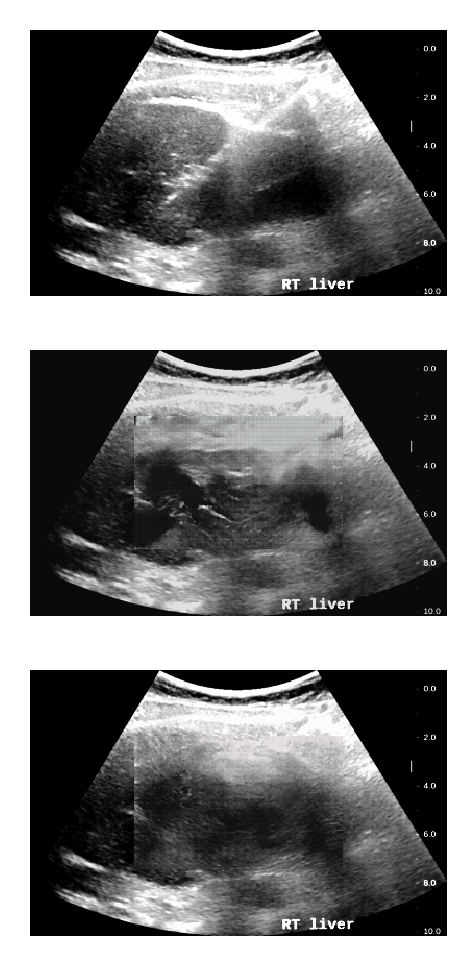

In [131]:
fig, axes = plt.subplots(nrows=3, dpi = 300)
axes[0].imshow(show_img(img, center))
axes[1].imshow(show_img(img, newd_pred))
axes[2].imshow(show_img(img, nod_pred))
#axes[3].imshow(show_img(img, d_pred))

[ax.set_axis_off() for ax in axes]

(-0.5, 399.5, 255.5, -0.5)

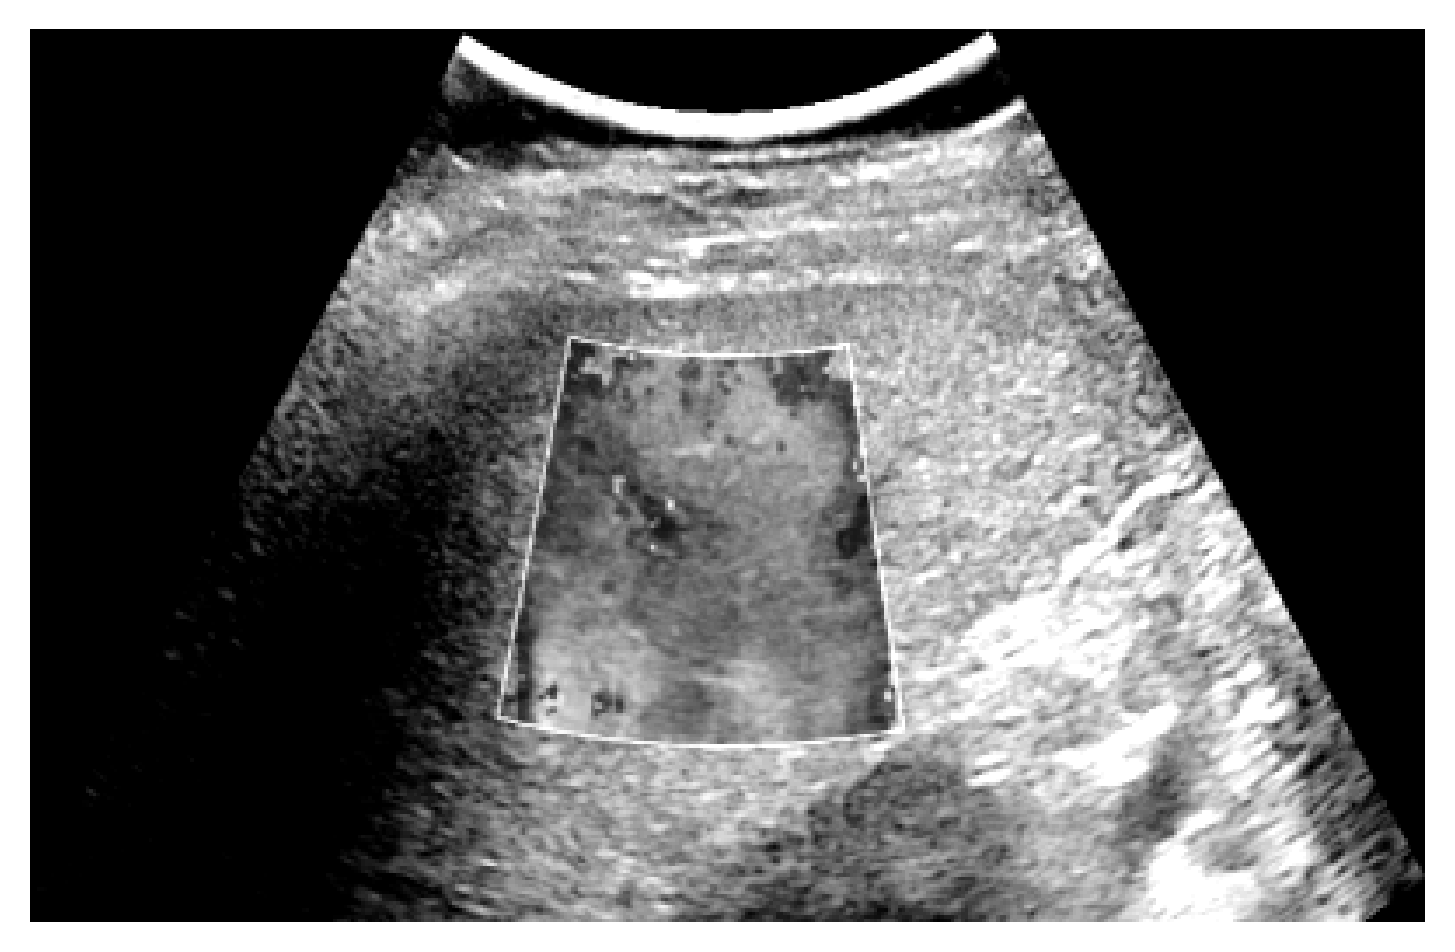

In [16]:
plt.figure(dpi=300)
plt.imshow(show_img(img,center))
#plt.imshow(show_img(img, newd_pred))
#plt.imshow(show_img(img,nod_pred))
plt.axis('off')

In [179]:
file_count = 0
study_date = set()
for path, dirs, files in os.walk('/mnt/SSI_milking/'):        
        try:            
            ds = pydicom.dcmread(os.path.join(path,files[0]))            
            study_date.add(ds.StudyDate)            
            print(ds.StudyDate)
        except Exception as e:
            print(e)
        

File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
list index out of range
list index out of range
list index out of range
20190307
20190823
list index out of range
20191022
list index out of range
20191007
20191029
20191112
20191126
list index out of range
list index out of range
20191003
list index out of range
20191017
list index out of range
20190213
20190812
list index out of range
20190102
20191025
list index out of range
20191121
list index out of range
20190222
20190417
20190418
list index out of range
20190304
20190214
list index out of range
20190321
20190702
list index out of range
20191113
list index out of range
20190405
20190924
20191101
list index out of range
20190719
list index out of range
20190118
20190219
20190118
20190107
20190123
20190128
20190109


KeyboardInterrupt: 

In [386]:
ds = pydicom.dcmread('/mnt/SSI_milking/Abdomen/General/US DRAINAGE CATHETER PLACEMENT/E13580834/I0000001')

In [13]:
pd.read_csv('../data/ssi.csv').ACC.nunique()

1188

In [387]:
ds.StudyDate

'20191003'

In [371]:
ssi = pd.read_csv('../data/ssi.csv')

In [372]:
ssi.shape

(12267, 6)

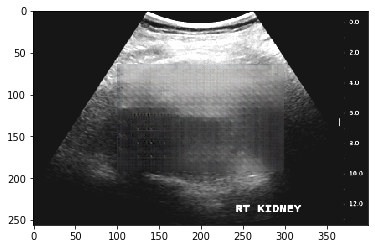

In [185]:
plt.imshow(show_img(img, nod_pred))

In [17]:
for study, encoding in study_dict.items():
    print(f'{study} & {",".join(encoding)} \\\\')

US BIOPSY LIVER NONFOCAL & liver,abdomen \\
US BIOPSY LIVER FOCAL & liver,abdomen \\
US LYMPH NODE BIOPSY & soft tissue,nodule \\
US BIOPSY KIDNEY NONFOCAL (EITHER SIDE) & kidney,abdomen \\
US PARACENTESIS THERAPEUTIC & abdomen,drainage \\
US BIOPSY TRANSPLANTED KIDNEY & kidney,abdomen \\
US PARACENTESIS DIAGNOSTIC AND THERAPEUTIC & abdomen,drainage \\
US THYROID BIOPSY & thyroid,nodule \\
US PARACENTESIS DIAGNOSTIC & abdomen,drainage \\
US THORACENTESIS DIAGNOSTIC AND THERAPEUTIC & chest,drainage \\
US THYROID ASPIRATION/FNA & thyroid,nodule \\
US DRAINAGE INTERVENTION NOT OTHERWISE SPECIFIED & soft tissue,drainage \\
US DRAINAGE ABDOMEN & abdomen,drainage \\
US DRAINAGE GALLBLADDER (CHOLECYSTOSTOMY) & abdomen,drainage \\
US THORACENTESIS THERAPEUTIC (RIGHT) & chest,drainage \\
US THORACENTESIS THERAPEUTIC (LEFT) & chest,drainage \\
US BIOPSY MESENTERY & abdomen,drainage,soft tissue \\
US NECK SOFT TISSUE BIOPSY & soft tissue,nodule \\
US DRAINAGE CATHETER PLACEMENT & soft tissue,drai